In [141]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
import plotly.express as px

## Simple EDA

In [142]:
train_df = pd.read_csv('hack/train.csv')
test_df = pd.read_csv('hack/test.csv')

# General info: number of NA and types 
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30860 entries, 0 to 30859
Data columns (total 52 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      30860 non-null  int64  
 1   Week    30860 non-null  int64  
 2   V1      30812 non-null  float64
 3   V2      30812 non-null  float64
 4   V3      23760 non-null  float64
 5   V4      23760 non-null  float64
 6   V5      23760 non-null  float64
 7   V6      23760 non-null  float64
 8   V7      23760 non-null  float64
 9   V8      23760 non-null  float64
 10  V9      23760 non-null  float64
 11  V10     23760 non-null  float64
 12  V11     23760 non-null  float64
 13  V12     23760 non-null  float64
 14  V13     23760 non-null  float64
 15  V14     23760 non-null  float64
 16  V15     23760 non-null  float64
 17  V16     23760 non-null  float64
 18  V17     23760 non-null  float64
 19  V18     23760 non-null  float64
 20  V19     23760 non-null  float64
 21  V20     23760 non-null  float64
 22

In [143]:
train_df.describe()
id_grouped = train_df.groupby('Id', as_index=0).std()

#Shown that for one Id tsrget is same by all weeks
id_grouped['target'].describe()

count    7715.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: target, dtype: float64

## Histograms which show distibution of columns by Week 

In [144]:
numeric_cols = number = train_df.iloc[:, 2:-1].columns.values
eda = True
if eda:
    # reduse number of columns for github)
    for col in  numeric_cols[:10]:
        px.histogram(train_df, x=col, color='Week', nbins=100).show()

## Preprocessing

In [145]:
all_numeric = pd.concat([train_df[numeric_cols], test_df[numeric_cols]])


### Before (deleted) we get count of NA values by target: when target ==1, count of na in columns is much bigger. So we have created a new column with mean of number of not na values by Id

In [146]:
not_na_mean = pd.DataFrame(train_df.iloc[:,:-1].groupby(['Id'], sort=False) \
    .apply(lambda x: x.count().mean()), columns=['not_na_mean'])
train_df = train_df.join(not_na_mean, on='Id')
not_na_mean = pd.DataFrame(test_df.groupby(['Id'], sort=False) \
    .apply(lambda x: x.count().mean()), columns=['not_na_mean'])
test_df = test_df.join(not_na_mean, on='Id')



### Fill NA values by more and more specific values in order: 
 - mean by Id
 - mean by Week
 - mode in full column (in teat and train)

In [147]:
for col in numeric_cols:
    train_df[col]=train_df.groupby(['Id'],
                                   sort=False)[col].apply(lambda x: x.fillna(x.mean()))
    test_df[col]=test_df.groupby(['Id'],
                                   sort=False)[col].apply(lambda x: x.fillna(x.mean()))

for col in numeric_cols:
    train_df[col]=train_df.groupby(['Week'],
                                   sort=False)[col].apply(lambda x: x.fillna(x.mean()))
    test_df[col]=test_df.groupby(['Week'],
                                   sort=False)[col].apply(lambda x: x.fillna(x.mean()))

for col in numeric_cols:
    col_mode = all_numeric[col].mode().iloc[0]
    train_df[col]=train_df[col].fillna(col_mode)
    test_df[col]=test_df[col].fillna(col_mode)

### Standart scaler fitted on both train and test

In [148]:
scaler = StandardScaler()

scaler.fit(all_numeric)
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
train_df.describe()

Id          Week            V1            V2            V3  \
count  3.086000e+04  30860.000000  30860.000000  30860.000000  30860.000000   
mean   5.880459e+16      1.500000      0.002686      0.003267      0.004004   
std    5.305951e+18      1.118052      1.006801      1.010506      0.876076   
min   -9.217316e+18      0.000000     -0.739342     -0.651214     -0.611939   
25%   -4.443360e+18      0.750000     -0.739342     -0.651214     -0.519350   
50%    6.482893e+16      1.500000     -0.308448     -0.309836     -0.120308   
75%    4.655320e+18      2.250000      0.365513      0.031542      0.004004   
max    9.222566e+18      3.000000      6.357726      8.907374     10.141509   

                 V4            V5            V6            V7            V8  \
count  30860.000000  30860.000000  30860.000000  30860.000000  30860.000000   
mean      -0.000875      0.001301      0.008700     -0.012242     -0.011023   
std        0.893334      0.871931      0.921299      0.872806      0.880127   
min       -0.591747     -0.327352     -0.168473     -1.125217     -1.075192   
25%       -0.476372     -0.327352     -0.168473     -0.581699     -0.546322   
50%       -0.080700     -0.327352     -0.168473     -0.012242     -0.011023   
75%       -0.000875      0.001301      0.008700      0.211058      0.149825   
max       11.324599     25.957100     18.221715      6.130580      8.508884   

       ...           P20           P21           P22           P23  \
count  ...  30860.000000  30860.000000  30860.000000  30860.000000   
mean   ...     -0.009071      0.005082     -0.032922      0.008256   
std    ...      1.015020      0.983633      0.993142      1.065975   
min    ...    -11.787486     -2.986139     -1.892737     -0.215814   
25%    ...     -0.412315     -0.516301     -0.712789     -0.215814   
50%    ...      0.256813     -0.174866     -0.253158     -0.215814   
75%    ...      0.758659      0.283037      0.412277     -0.215814   
max    ...      0.925941     21.014886     11.834446     24.320791   

                P24           P25           P26           P27        target  \
count  30860.000000  30860.000000  30860.000000  30860.000000  30860.000000   
mean      -0.005460     -0.003762      0.052611      0.011837      0.173169   
std        1.012893      1.009855      1.056359      1.015701      0.378400   
min      -11.551307     -1.486247     -1.036856     -1.341567      0.000000   
25%       -0.324570     -0.964317     -0.572127     -0.794123      0.000000   
50%        0.318530      0.098473     -0.282110     -0.182714      0.000000   
75%        0.638257      0.883341      0.289619      0.617447      0.000000   
max        0.957983      1.551134     37.320709      2.576461      1.000000   

        not_na_mean  
count  30860.000000  
mean       3.439086  
std        1.045805  
min        0.176471  
25%        4.000000  
50%        4.000000  
75%        4.000000  
max        4.000000  

[8 rows x 53 columns]

## Model Selecting and training

### Our Logic: 
1. train 4 models (1 for each week)
2. after concatenate all proba in dataset. 
3. The final model will be trained on this dataset (I know in result we have smth like Voting ensemble)

There were many models which have been tested: from simple KNN (for this model fillna was different) to different ensembles. We stoped at GradientBoostingClassifier

In [149]:
train_res = []
test_res = []

for week, df in train_df.groupby('Week', as_index=False, sort=False):
    X_train = df.drop(columns=['Id', 'Week', 'target'])
    y = df.target.to_numpy()
    X_test = test_df[test_df['Week']==week].drop(columns=['Id', 'Week'])

    model = GradientBoostingClassifier(n_estimators=1000)
    param = {'learning_rate':[0.7],
              'max_depth':[3],
              'max_features': [0.95]}
    clf = GridSearchCV(model, param, cv=6, scoring=make_scorer(roc_auc_score), n_jobs=-1, refit=True)
    clf.fit(X_train, y)
    
    res_columns = ['0_week'+str(week), '1_week'+str(week)]
    pred_train = clf.best_estimator_.predict_proba(X_train)
    pred_test = clf.best_estimator_.predict_proba(X_test)

    train_res.append(pd.DataFrame(pred_train, columns=res_columns))
    test_res.append(pd.DataFrame(pred_test, columns=res_columns))

    print('Best score: ', clf.best_score_, clf.best_estimator_)
    print(clf.best_params_)


Best score:  0.7900720072896098 GradientBoostingClassifier(learning_rate=0.7, max_features=0.95,
                           n_estimators=1000)
{'learning_rate': 0.7, 'max_depth': 3, 'max_features': 0.95}
Best score:  0.7925059042369537 GradientBoostingClassifier(learning_rate=0.7, max_features=0.95,
                           n_estimators=1000)
{'learning_rate': 0.7, 'max_depth': 3, 'max_features': 0.95}
Best score:  0.7864817779298597 GradientBoostingClassifier(learning_rate=0.7, max_features=0.95,
                           n_estimators=1000)
{'learning_rate': 0.7, 'max_depth': 3, 'max_features': 0.95}
Best score:  0.7812848188408031 GradientBoostingClassifier(learning_rate=0.7, max_features=0.95,
                           n_estimators=1000)
{'learning_rate': 0.7, 'max_depth': 3, 'max_features': 0.95}


In [150]:
concat_train = pd.concat(train_res, axis=1)
concat_test = pd.concat(test_res, axis=1)
concat_y = train_df.groupby('Id', sort=False).first()['target']

concat_model = LogisticRegressionCV(cv=5,  scoring=make_scorer(roc_auc_score))
concat_model.fit(concat_train, concat_y)
print(roc_auc_score(concat_y, concat_model.predict(concat_train)))
concat_train.head()

1.0


0_week0       1_week0   0_week1       1_week1   0_week2       1_week2  \
0  0.999926  7.428807e-05  0.999999  1.458358e-06  1.000000  3.274163e-07   
1  1.000000  1.810558e-07  0.999460  5.396863e-04  0.999974  2.579957e-05   
2  1.000000  7.430073e-11  1.000000  2.231901e-10  1.000000  1.248412e-10   
3  0.999999  5.456771e-07  1.000000  1.476714e-10  0.999996  4.179113e-06   
4  1.000000  4.545015e-08  1.000000  3.256243e-09  0.999996  3.753116e-06   

    0_week3       1_week3  
0  1.000000  1.982997e-08  
1  0.999863  1.369978e-04  
2  1.000000  2.597116e-08  
3  1.000000  1.099591e-07  
4  0.999999  6.522951e-07

In [151]:
submit_y = concat_model.predict_proba(concat_test)

### A little bit of magic to fix distribution of our result 

array([[<AxesSubplot:title={'center':'Predicted'}>]], dtype=object)

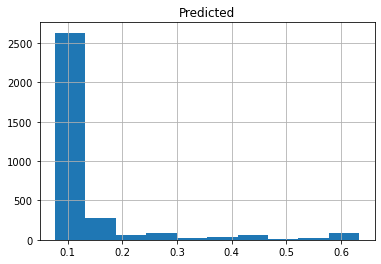

In [152]:
submit = test_df.groupby('Id', sort=False, as_index=False).first()[['Id']]
submit['Predicted'] = submit_y[:,1]
submit.hist('Predicted')

array([[<AxesSubplot:title={'center':'Predicted'}>]], dtype=object)

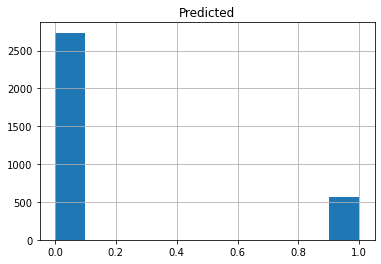

In [153]:
submit['Predicted'] = submit['Predicted'].apply(lambda x: 0 if x <0.15 else 1)
submit.hist('Predicted')

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

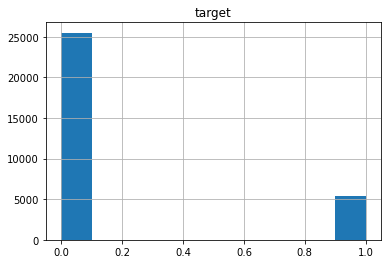

In [154]:
train_df.hist('target')

In [155]:
submit.to_csv('hack/sub_final.csv',index=False)